# MSK-Modulation

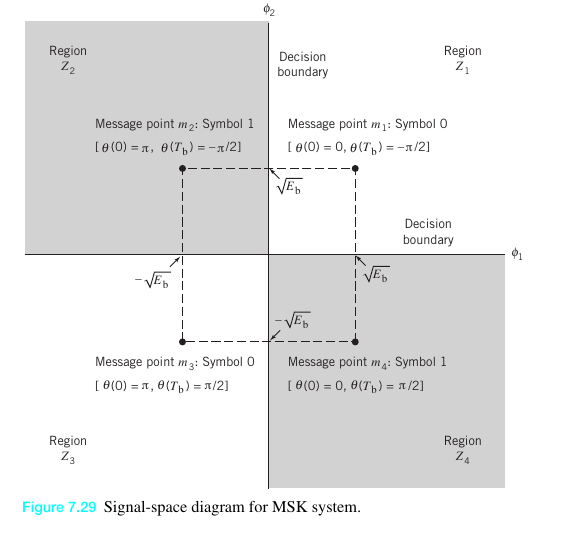 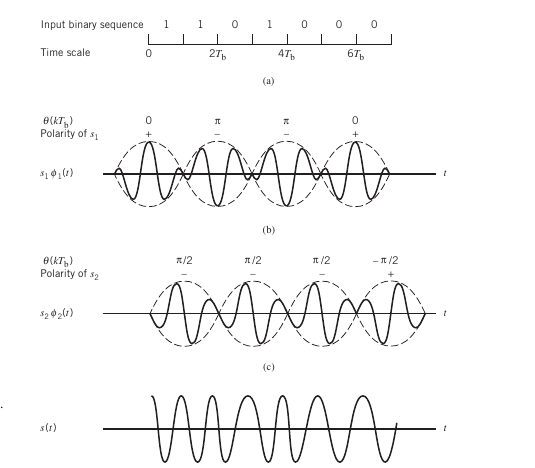


In [2]:
#pip install numpy --user
#!pip install matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
import math

In [4]:
# function that creates a random array of 0 and 1 

def random_generator(nBits):
    bits = []
    for i in range(nBits):
        bit = random.randint(0, 1)
        bits.append(bit)
    return bits

In [5]:
def preCoding(y):
    x = [y[0]]
    for i in range(1, len(y)):
        x.append(y[i]*y[i-1])
    x = np.array(x)
    return x

In [6]:
# Function that increases the number of signal samples by adding nSamp-1 zeros after every sample 

def upSample(signal, nSamp):
    upSampled = []
    for i in range(len(signal) * nSamp):
        if i % nSamp == 0:
            upSampled.append(signal[i // nSamp])
        else:
            upSampled.append(0)
    return upSampled

In [7]:
def awgn(signal, SNR_db):

    #  adds white Gaussian noise to signal
    P = sum(np.multiply(signal,signal)) / len(signal)
    P_db = 10 * np.log10(P)
    Pn_db = P_db - SNR_db
    Pn = 10 ** (Pn_db * 0.1)
    
    sigma = np.sqrt(Pn)
    noise = np.random.normal(0, sigma, len(signal))
    noisySignal = signal + noise
        
    return noisySignal

In [8]:
def mskErrors(nBits, nSamp, EbN0_db, toPrecode,check):
    R = 270833  # bit rate 
    #fc = 3 * R  # carrying frequency
    fc=5000000   #in exersice we have fc=5Ghz 
    ns = nSamp  # sampling frequency
    T = 1 / R   #1 bit period
    Ts = T / ns
    
    
    # generate random input binary wave (ΝR Z)
    y = random_generator(nBits) 
    
   
    for i in range (0,len(y)):
        y[i] = 2 * y[i] - 1
    
    
    if(toPrecode):
        x = preCoding(y) # with precoding
    else:
        x = y # without
    
    # Sampling of wave 
    g = np.ones(ns)
    xUpsampled = upSample(x, ns)
    xx = np.convolve(xUpsampled, g) #samples of NRZ 
    
    if(check): 
        plt.figure()
        plt.plot(xx)
        plt.grid()
        plt.xlim(100,150)
        plt.title("NRZ in polar form")
        plt.show()
    
    # MSK-Transmitter 
    xs = xx
    ts = np.arange(0, (len(xs)+1) * Ts, Ts)

    # Calculate the phase of the modulated MSK signal 
 
    theta = np.cumsum(xs) * np.pi / 2 / ns
    
    if(check):
        plt.figure()
        plt.plot(theta)
        plt.ylabel("θ(t)")
        plt.xlabel("Xρονος (xT)")
        #plt.xlim(100,500)
        plt.grid()
        plt.show()
    # symfasiki synistwsa 
    xs_i = np.cos(theta) 
    xs_i = np.append(xs_i, xs_i[-1])
    
    if(check):
        plt.figure()
        plt.plot(xs_i)
        plt.title("symfasikh synistwsa")
        plt.xlim(100,150)
        plt.grid()
        plt.show()
    # egkarsia synistwsa
    xs_q = np.sin(theta) 
    xs_q = np.append(xs_q, xs_q[-1])
    if(check):
        plt.figure()
        plt.plot(xs_q)
        plt.title("or8ogwnikh synistwsa")
        plt.xlim(100,150)
        plt.grid()
        plt.show()
    # Signal for transmission  (QAM)
    s = xs_i * np.cos(2 * np.pi * fc * ts) - xs_q * np.sin(2 * np.pi * fc * ts)
    
  

    SNR_db = EbN0_db - 10 * np.log10(ns / 2) #AWGN Channel
    s = awgn(s,SNR_db) # adding AWGN
    
    
    
    # Filter (Parks-McClellan)
    f1 = 0.75 / ns
    f2 = 4 * f1
    filterOrder = 4 * ns
    numTaps = filterOrder + 1
    bands = [0, f1, f2, 0.5]
    desired = [1, 0]
    b = scipy.signal.remez(numTaps, bands, desired) 
    #Calculate the minimax optimal filter using the Remez exchange algorithm.

    if(check):
        plt.figure()
        plt.plot(b)
        plt.title("Κρουστική Απόκριση ελάχιστου φίλτρου ")
        plt.grid()
        plt.show()

   
        
    # MSK-Receiver
    
    # demod QAM
    xs_i = s * np.cos(2 * np.pi * fc * ts)
    xs_q = -s * np.sin(2 * np.pi * fc * ts)

    # Lowpass filtering of xs_i,xs_q
    a = 1
    to_filter = np.concatenate([xs_i, np.zeros(filterOrder)]) 
    filtered_i = scipy.signal.lfilter(b, a, to_filter)
    delay = filterOrder // 2 # filter delay
    xs_i = filtered_i[delay : len(filtered_i)-delay] #  cut tails due to convolution

    to_filter = np.concatenate([xs_q, np.zeros(filterOrder)])
    filtered_q = scipy.signal.lfilter(b, a, to_filter)
    xs_q = filtered_q[delay : len(filtered_q)-delay] # cut tails due to convolution
    
    if(check):
        plt.figure()
        plt.stem(xs_i,use_line_collection=True)
        #plt.plot(xs_i)
        plt.xlim(100,150)
        plt.title("Συμφασική συνιστώσα μετα το φιλτράρισμα (demod)")
        plt.grid()

        plt.figure()
        plt.stem(xs_q,use_line_collection=True)
        plt.xlim(100,150)
        #plt.plot(xs_q)
        plt.title("Oρθογωνική συνιστώσα μετα το φιλτράρισμα (demod)")
        plt.grid()
    # Recognize the received digits in pairs of bits due to the modulation of information in two components 
    # with an offset in between them by digit pediod T_b
    
    bi = 1
    xr_1 = 1
    xr = np.zeros(nBits) #signal that is constructed by the value of the phases in xs_q,xs_i 
                        #by comparison with the original we find BER
    for k in range (1,nBits, 2):
        
        # li ,lq are shifting time grids of 2 periods
        # 2*ns points each with offset in between tham
        li = np.arange(k*ns, (k+2)*ns)
        lq = np.arange((k-1)*ns, (k+1)*ns)
        xi = xs_i[li]
        xq = xs_q[lq]
        
        # matched-filter pulse 
        gmi = np.cos(np.pi/2/T*Ts*li)
        gmq = -gmi # gmq = np.sin(np.pi/2/T*Ts*lq)
        
   
        #if(check and k < 10)
        if(check and k>12 and k<14): 
            plt.figure()
            plt.plot(li,gmi,label='Συμφασική ')
            plt.plot(lq,gmq,label='Ορθογωνική ')
            plt.grid()
            plt.xlabel('Χρονος(xT) (Διάστημα εκπομπής των bits)')
            plt.ylabel('Si(t) , Sq(t)')
            plt.legend()
            plt.show()  
        #To bi isxyei apo to epomeno k afoy sthn msk h symfasikh synistwsa epetai kata mia periodo psifioy T_b 
        #apo thn or8ogwniki
        bi_1 = bi
        
        #numpy.sign(x[, out])  returns -1 if x < 0, 0 if x==0, 1 if x > 0.
        bi = np.sign(sum(np.multiply(xi,gmi)))
        bq = np.sign(sum(np.multiply(xq,gmq)))
        
        if(toPrecode):
            xr[k-1] = xr_1*bi_1*bq  
            xr[k] = xr[k-1]*bi*bq
            xr_1 = xr[k]
        else:
            xr[k-1] = bi_1*bq
            xr[k] = bi*bq

            
             
    if(check): 
        plt.figure()
        plt.plot(xr)
        plt.grid()
        plt.xlim(100,150)
        plt.title("Final form of retrieving signal in receiver")
        plt.show()
    # Calculate errors 
    
    if(toPrecode):
        errors = sum(abs(y-xr)>0.1)
    else:
        errors = sum(abs(x-xr)>0.1)
        
    return errors



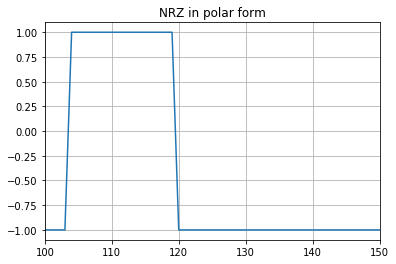

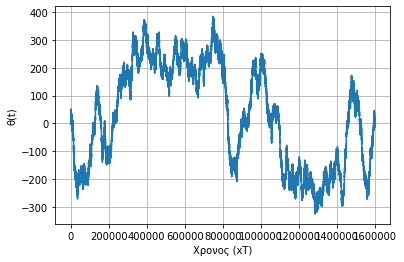

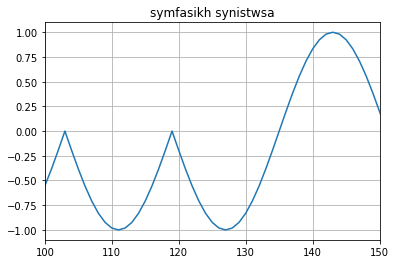

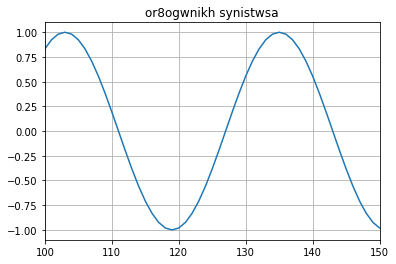

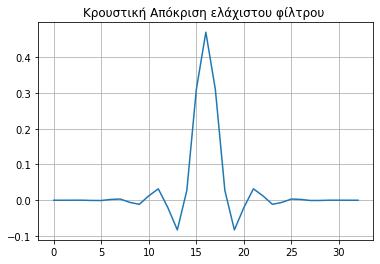

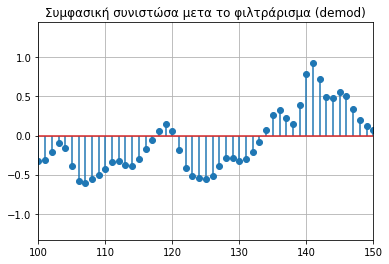

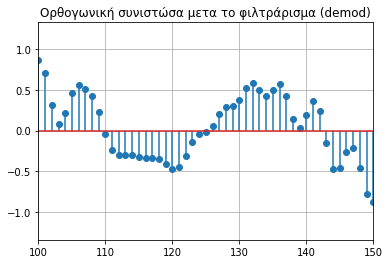

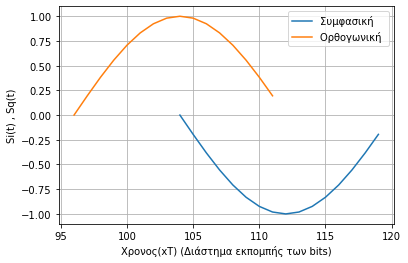

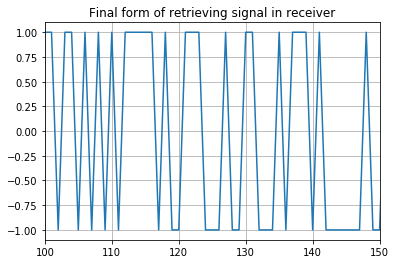

In [10]:
#plot curves in time interval of 100 to 110 bits for a specific value of EB/NO in dB
toPrecode=True
check=True
nBits = 200000
nSamp = 8
EbN0_db=12
Pb= mskErrors(nBits, nSamp,EbN0_db,toPrecode,check)
   
    

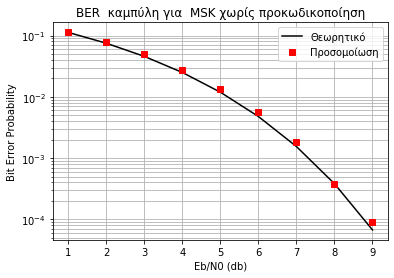

In [9]:
#Without precoding 
BER = []
BERtheor = []

check=False
toPrecode = False
nBits = 200000
nSamp = 8
for EbN0_db in range(1,10):
    EbN0 = 10**(0.1*EbN0_db)
    Pb= mskErrors(nBits, nSamp, EbN0_db, toPrecode,check)
    BER.append(Pb / nBits)
    BERtheor.append(scipy.special.erfc(np.sqrt(EbN0)))
    
    
x_axis = np.arange(1,10,1)

plt.figure()
plt.semilogy(x_axis,BERtheor,color='black')
plt.semilogy(x_axis,BER, 's',color='red')
plt.legend(['Θεωρητικό','Προσομοίωση'])
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Probability')
plt.title('BER  καμπύλη για  MSK χωρίς προκωδικοποίηση')
plt.grid(which='both')
plt.show()

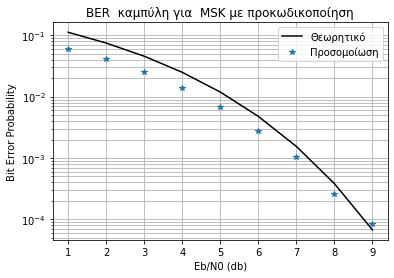

In [10]:
BER_precod = []
BERtheor = []

check=False
toPrecode = True
nBits = 200000
nSamp = 8
for EbN0_db in range(1,10):
    EbN0 = 10**(0.1*EbN0_db)
    Pb = mskErrors(nBits, nSamp, EbN0_db, toPrecode,check)
    BER_precod.append(Pb / nBits)
    BERtheor.append(scipy.special.erfc(np.sqrt(EbN0)))
    
    
x_axis = np.arange(1,10,1)

plt.figure()
plt.semilogy(x_axis,BERtheor,color='black')
plt.semilogy(x_axis,BER_precod, '*')
plt.legend(['Θεωρητικό','Προσομοίωση'])
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Probability')
plt.title('BER  καμπύλη για  MSK με προκωδικοποίηση')
plt.grid(which='both')
plt.show()

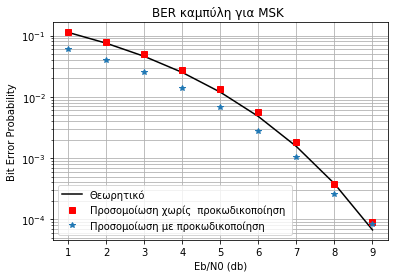

In [11]:
plt.figure()
plt.semilogy(x_axis,BERtheor,color='black')
plt.semilogy(x_axis,BER, 's',color='red')
plt.semilogy(x_axis,BER_precod, '*')
plt.legend(['Θεωρητικό','Προσομοίωση χωρίς  προκωδικοποίηση ','Προσομοίωση με προκωδικοποίηση '])
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Probability')
plt.title('BER καμπύλη για MSK ')
plt.grid(which='both')
plt.show()